### Historical Shape Indicator (HSI),  Daily ETL

In [1]:
import pandas as pd
from pandas import DatetimeIndex
from pandas.plotting import table
import datetime 
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set()
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from alpha_vantage.timeseries import TimeSeries
import pickle
from joblib import dump, load
import time
import six

#### Download Data

In [2]:
def get_raw(sym='V'):
    '''
    download data and return data dictionary
    '''
    # download historical prices
    ts = TimeSeries(key='enter your access key')
    # Get json object with the intraday data and another with  the call's metadata
    data, meta_data = ts.get_daily_adjusted(sym, outputsize='compact')
    return data

def format_raw(raw_dict):
    '''
    import raw dictionary
    format column names and sort date ascending
    return dataframe
    '''
    # reformat
    data = raw_dict.copy()
    df_raw = pd.DataFrame.from_dict(data).T
    df_raw.reset_index(level=0, inplace=True)
    df_raw = df_raw.rename(index=str, columns={'index':'date',
                                               '1. open': 'open', 
                                               '2. high': 'high',
                                               '3. low': 'low',
                                               '4. close':'close',
                                               '5. adjusted close':'adj_close',
                                               '6. volume':'volume',
                                               '7. dividend amount':'dividend',
                                               '8. split coefficient':'split',
                                              })
    df_raw = df_raw.sort_values(by='date', ascending=True)
    df_raw = df_raw.reset_index(drop=True)
    df_raw.date = pd.to_datetime(df_raw.date)
    
    return df_raw

In [3]:
def scale_adjusted(df_raw):
    '''
    import raw dataframe
    scale open,high,low, close to adjusted close
    return updated dataframe
    '''
    df = df_raw.copy()
    df_scale = pd.DataFrame()
    close = df.close.to_numpy().astype(float)
    adj = df.adj_close.to_numpy().astype(float)
    scale = adj / close
    df_scale['date'] = df['date'].copy()
    df_scale['open']=df.open.to_numpy().astype(float)*scale
    df_scale['high']=df.high.to_numpy().astype(float)*scale
    df_scale['low']=df.low.to_numpy().astype(float)*scale
    df_scale['close']=df.close.to_numpy().astype(float)*scale
    
    return df_scale

#### Preprocess Data

In [4]:
def compute_day_shape(prices, sigmas, dayspan):
    '''
    compute one day shape
    '''
    abs_deltas = (prices) - (prices.shift(dayspan))
    s_ratios = abs_deltas / sigmas
    ups = 3*(s_ratios>1)
    downs = 1*(s_ratios<-1)
    neuts = 2*((s_ratios>=-1)&(s_ratios<=1))      
    return (ups+downs+neuts)

def compute_shape(dayshape, dayspan):
    '''
    compute 5 day shape ordinals
    '''
    ago5s = 10000*(dayshape.shift(4*dayspan))
    ago4s = 1000*(dayshape.shift(3*dayspan))
    ago3s = 100*(dayshape.shift(2*dayspan))
    ago2s = 10*(dayshape.shift(1*dayspan))
    return (ago5s+ago4s+ago3s+ago2s+dayshape)

In [5]:
def preprocess(df):
    '''
    compute statistics 
    use day shape spans of 1, 3 and 5 days
    build shape ordinals for day data
    '''
    df_for = df.copy()
    
    # raw data overlaps
    shifts = [['o1','h1','l1','c1'],
              ['o2','h2','l2','c2'],
              ['o3','h3','l3','c3'],
              ['o4','h4','l4','c4'],
             ]
    # format df to calculate price estimates and standard deviations
    for j, shift in zip(range(1,6),shifts):
        df_for[shift[0]] = df_for.open.shift(-j)
        df_for[shift[1]] = df_for.high.shift(-j)
        df_for[shift[2]] = df_for.low.shift(-j)
        df_for[shift[3]] = df_for.close.shift(-j)

    # define price estimate columns for 1,3,5 day spans
    p1_col = df_for.loc[:,"open":"close"].astype(float)
    p3_col = df_for.loc[:,"open":"c2"].astype(float)
    p5_col = df_for.loc[:,"open":"c4"].astype(float)  
    p_cols = [p1_col, p3_col, p5_col]

    # compute price estimates and standard deviations for spans
    stats = [['pe1','sd1'],['pe3','sd3'],['pe5','sd5']]
    for stat, p_col in zip(stats, p_cols):
        df_for[stat[0]] = p_col.mean(axis=1)
        df_for[stat[1]] = p_col.std(axis=1)

    # keep date but leave raw data behind
    df_prep = df_for[['date','pe1','sd1','pe3','sd3','pe5','sd5']].copy()
    
    # add day shapes to df
    dayshapes = ['ds1','ds3','ds5']
    dayspans = [1,3,5]
    for shape, stat, span in zip(dayshapes, stats, dayspans):
        df_prep[shape] = compute_day_shape(df_prep[stat[0]], df_prep[stat[1]], span)
        
    # add shapes to df
    shapes = ['shp1','shp3','shp5']
    for shape, dayshape, span in zip(shapes, dayshapes, dayspans):
        df_prep[shape] = compute_shape(df_prep[dayshape], span)

    #trim the head then format
    df_trim = df_prep[25:].copy()
    df_trim[['shp1','shp3','shp5']] = df_trim[['shp1','shp3','shp5']].astype(int)
    
    return df_trim

In [6]:
def assign_hsi(df, df_shape):
    '''
    for daily market data
    lookup the HSI figures given shape ordinals
    return updated dataframe with daily HSC assignment
    '''
    df_mkt = df.copy()
    
    # HSI lookups
    shapenames = ['shp1','shp3','shp5']
    hsi_names = ['hsi1','hsi3','hsi5']
    
    for sname, hsi_name in zip(shapenames, hsi_names):
        lookups = []
        s_list = df_shape[sname]['shape'].tolist()
        for i,nrows in df_mkt.iterrows():
            shp = nrows[sname]
            # assign last known(or 0.5) for unknown shapes
            if shp in s_list:
                lookups.append(np.asscalar(df_shape[sname]\
                    [df_shape[sname]['shape']==shp]['HSI'].values))
            else:
                try:
                    lookups.append(lookups[-1])
                except:
                    lookups.append(0.5)
        df_mkt[hsi_name] = lookups
        
    # compile three into the average of the two closest
    nearest_two = []
    for i,nrows in df_mkt.iterrows():
        v1 = nrows['hsi1']
        v2 = nrows['hsi3']
        v3 = nrows['hsi5']
        diffs = np.abs([v1-v2, v2-v3, v1-v3])
        sums = [v1+v2, v2+v3, v1+v3]
        nearest_two.append(np.max((diffs==np.amin(diffs))*sums)/2)
        
    df_mkt['HSC'] = nearest_two

    return df_mkt

#### Identify Trade Opportunities

In [7]:
def compute_trades(indicator, highT, lowT):
    '''
    compare HSC to thresholds
    return binaries of in/out days
    '''
    trades = []
    inout = 0
    for ind in indicator:
        # from out to enter
        if inout == 0:
            if ind > highT:
                trades.append(1)
                inout = 1
            else:
                trades.append(0)
        # from in to exit
        else:
            if ind < lowT:
                trades.append(0)
                inout = 0
            else:
                trades.append(1)
    return trades

In [8]:
def find_trade_masks(trade_array):
    '''
    Import optimal trade in/out boolean array
    Export buy and sell day masks
    '''
    trades = trade_array.copy()
    num_days = len(trades)
    # number of days after threshold crossing
    late = 2
    
    # trade changes as threshold crossings
    difference = np.diff(trades)
    
    # optimal threshold day indices
    buys = np.where(difference==1)
    sells = np.where(difference==-1)
    
    # optimals + late day indices using heavy numpy
    late_days = np.arange(late)
    buy_index_array = np.unique(np.sort(np.add(np.tile(
        late_days,[len(buys[0]),1]).T,buys[0]).flatten()))
    sell_index_array = np.unique(np.sort(np.add(np.tile(
        late_days,[len(sells[0]),1]).T,sells[0]).flatten()))
    
    # truncate those out of range
    buy_index_array = buy_index_array[buy_index_array<num_days]
    sell_index_array = sell_index_array[sell_index_array<num_days]
    
    # build mask arrays from indices
    buy_mask_array = np.zeros(num_days, dtype=int)
    buy_mask_array[buy_index_array] = 1
    sell_mask_array = np.zeros(num_days, dtype=int)
    sell_mask_array[sell_index_array] = 1
    
    return buy_mask_array, sell_mask_array

In [9]:
def add_class_fields(df_trades):
    '''
    import consolidated summaries
    add symbol category and year fields
    return updated dataframe
    '''
    df = df_trades.copy()
    # Add symbol ordinals
    with open('dict_symbolcat.pkl', 'rb') as handle:
        d_symcat = pickle.load(handle)
    
    symcat = list(map(lambda x: d_symcat[x], df.symbol.tolist()))
    df['sym'] = symcat
    
    # Add year column
    df.date = pd.to_datetime(df.date)
    df['year'] = df['date'].map(lambda x: x.year)
    
    return df

#### Classify Trades

In [10]:
def class_trades(df_trade):
    '''
    Import trade dataframe
    Load trained classifier
    Predict high return trade classification
    Return updated dataframe
    '''
    df = df_trade.copy()
    
    if len(df) > 0:
        # load models
        logreg = load('logreg_model.joblib')
        # specify the same features as model trainings
        class_cols = ['HSC', 
            'ds1', 'ds3', 'ds5',
            'hsi1', 'hsi3', 'hsi5',
            'pe1', 'pe3', 'pe5', 
            'sd1', 'sd3', 'sd5',
            'shp1', 'shp3', 'shp5', 
            'sym','year']
        # model predictions
        df_class = df[class_cols].copy()
        df['year'] = df['year'].astype(float)
        df['pred'] = logreg.predict(df_class)
        df['prob'] = logreg.predict_proba(df_class).T[1]
    
    return df

In [11]:
def assign_actions(df_trade, lowT, highT):
    '''
    identify buy and sell day possibilities
    return dataframe with buy sell boolean fields
    '''
    df = df_trade.copy()
    
    # get trade mask possibilities
    trades = df['trade'].to_numpy()
    buys, sells = find_trade_masks(trades)
    
    # mask for those above or below thresholds
    HSC = df['HSC'].to_numpy()
    b_ok = (HSC>highT)*1
    s_ok = (HSC<lowT)*1
    
    # check that the classifier is agreeable
    pred = df['pred'].to_numpy()
    c_ok = (pred==1)*1
    
    # assign buy and sell boolean flags
    df['buyday'] = (buys*b_ok)*c_ok
    df['sellday'] = (sells*s_ok)*c_ok
    
    return df

In [12]:
def summarize(df_actions):
    '''
    import action dataframe
    check for buy sell opportunities in last five days
    return slices where true
    '''
    df = df_actions.tail()
    dates = df.date.unique()
    df_sum = pd.DataFrame()
    for date in dates:
        #buy days
        df_slice = df[(df['date']==date)&(df['buyday']==1.)]
        if len(df_slice)>0:
            df_sum = df_sum.append(df_slice.iloc[0])
        #sell days    
        df_slice = df[(df['date']==date)&(df['sellday']==1.)] 
        if len(df_slice)>0:
            df_sum = df_sum.append(df_slice.iloc[0])
            
    return df_sum 

#### Rank Trade Opportunities

In [13]:
def rank_score(df_trades):
    '''
    import trade opportunity dataframe
    rank sort by assigned high return probabilities
    return ranked dataframe
    '''
    df = df_trades.copy()
    # sort descending
    df = df.sort_values(by='prob', ascending=False)
    
    return df

#### Build Report Image for Static Website

In [14]:
def build_image(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    
    '''
    import dataframe
    write dataframe to image file
    return image
    '''
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            
    # add image file export
    folder = 'images/'        
    plt.savefig(folder+'report.png')
    
    return ax

#### ETL Pipeline

In [15]:
def pipe_etl_pre(ticker, df_threshold):
    '''
    run ETL pre-processing pipeline
    '''
    print('Runnning ETL for '+ ticker)
    dict_raw = get_raw(ticker)
    
    print('formatting')
    df_for = format_raw(dict_raw)
    df_scale = scale_adjusted(df_for)
    
    print('preprocessing')
    df_pre = preprocess(df_scale)
    df_pre['symbol'] = ticker
    
    print('assigning shapes')
    df_shape = pd.read_csv('hsi_data/{}_hsi.csv'.format(ticker),
                       header=[0, 1], skipinitialspace=True, 
                       tupleize_cols=True)
    df_shape.columns = pd.MultiIndex.from_tuples(df_shape.columns)
    df_ind = assign_hsi(df_pre, df_shape)

    print('loading trade thresholds')
    lowT = df_threshold[df_threshold['ticker']==ticker]['lowT'].values[0]
    highT = df_threshold[df_threshold['ticker']==ticker]['highT'].values[0]
        
    print('computing indicated trades')
    trades = compute_trades(df_ind['HSC'].tolist(), highT, lowT)
    df_ind['trade'] = trades
    
    print('classifying trades')
    df_class = add_class_fields(df_ind)
    df_class = class_trades(df_class)
        
    print('finding trade opportunities')
    df_act = assign_actions(df_class, lowT, highT)
        
    print('sumarizing latest trade days')
    df_sum = summarize(df_act)
        
    return df_sum

In [16]:
def pipe_etl_post(df_trades):
    '''
    run ETL post-processing pipeline
    rank sorts, formats, exports image
    '''
    df = df_trades.copy()
    
    print('ranking trades')
    df_out = rank_score(df)
    
    print('formatting dataframe')
    act_bool = df_out['sellday'].to_numpy()
    act_strings = np.where(act_bool==1., 'SELL', 'BUY')
    df_out['action'] = act_strings
    out_cols = ['date','symbol','action','pe1','prob','pred']
    df_form = df_out[out_cols]
    df_form = df_form.rename(columns={"pe1": "price", 
                                      "prob": "score", 
                                      "pred": "class"})
    df_form = df_form.sort_values(['date','score'], ascending=[False, False])
    df_form['price'] = df_form['price'].round(decimals=2)
    df_form['score'] = df_form['score'].round(decimals=2)
    df_form['date'] = df_form['date'].dt.strftime('%Y-%m-%d')
    
    print('exporting image and finishing')
    build_image(df_form[:25], header_columns=0, col_width=1.5);
    
    return

#### Run ETL

downloading thresholds with tickers
running pre-processing etl
Runnning ETL for ENTG
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for JBSS
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for TMHC
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for FAF
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for PRFT
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumariz

Runnning ETL for CW
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for CF
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for WST
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for TGT
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for GWR
formatting
preprocessing
assigning shapes
loading trade thresholds
computing indicated trades
classifying trades
finding trade opportunities
sumarizing latest trade days
Runnning ETL for CHD
formatting
preprocessing
a

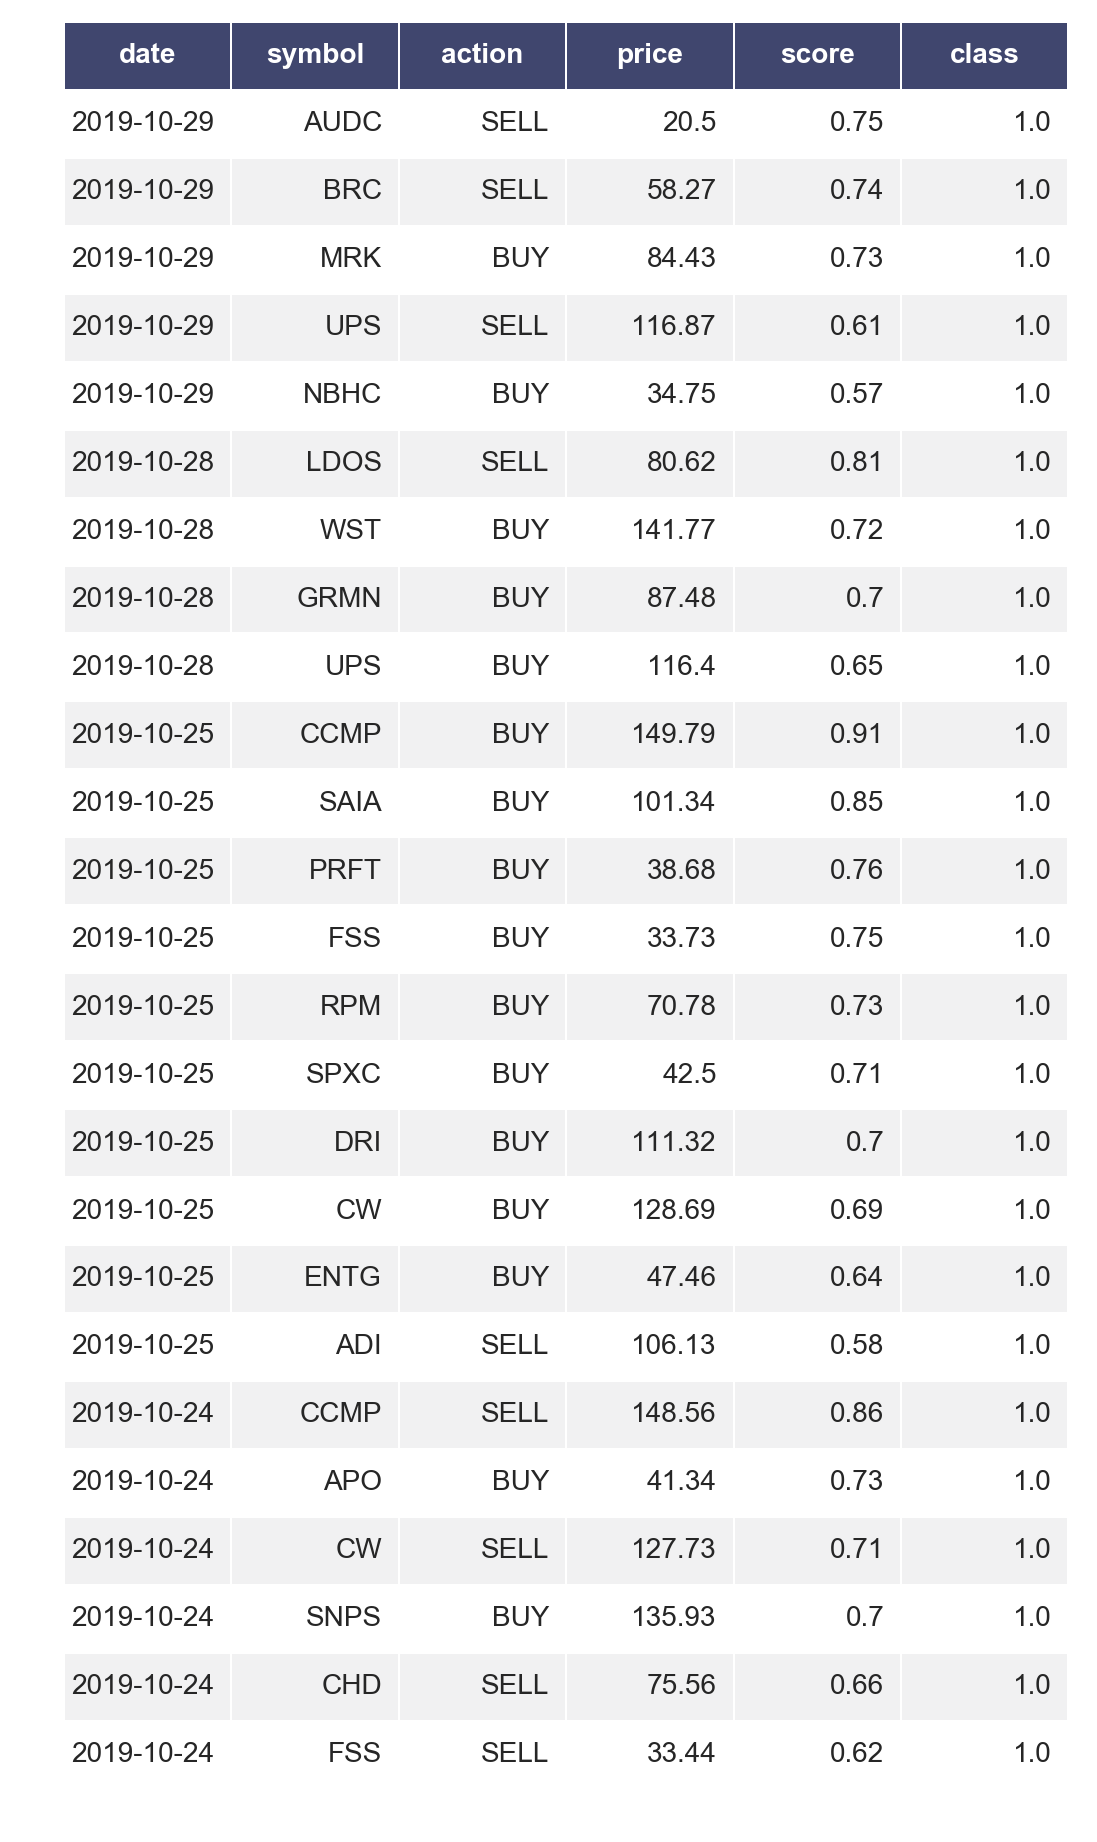

In [17]:
print('downloading thresholds with tickers')
df_threshold = pd.read_csv('hsi_thrsh.csv')
t_list = df_threshold.ticker.unique().tolist()

print('running pre-processing etl')
df_tradedata = pd.DataFrame()
except_list = []
for ticker in t_list:
    try:
        df_ticker = pipe_etl_pre(ticker, df_threshold)
        df_ticker['symbol'] = ticker
        df_tradedata = pd.concat([df_tradedata, df_ticker], ignore_index=True)
    except:
        except_list.append(ticker)
    # add delay between calls to reduce server hiccups
    time.sleep(10)
    
print('appending class fields')    
df_trades = add_class_fields(df_tradedata)
    
print('running post-processing etl')
pipe_etl_post(df_trades)

In [18]:
print(except_list)

[]


### Disclaimer: this notebook is intended for educational purposes only and not recommended for real trading.